<a href="https://colab.research.google.com/github/guohere/Neural-networks-zero-to-here/blob/main/makemore1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [178]:
# SPlit the dataset
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  # print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [20]:
# build lookup table C
C = torch.randn((27, 2))
C[5]

tensor([ 0.0111, -0.4333])

In [32]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.0111, -0.4333])

In [77]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [48]:
# Hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [54]:
h = emb.view(-1, 6) @ W1 + b1

In [53]:
h.shape

torch.Size([32, 100])

In [51]:
h

tensor([[-0.8448,  1.1060,  2.1787,  ...,  1.5125,  0.5534, -1.7965],
        [-1.4538,  1.3155, -0.0261,  ...,  0.5378,  0.6485, -0.3842],
        [-1.3701,  2.3120,  0.4247,  ...,  1.2835,  3.1846, -2.7309],
        ...,
        [-1.8695,  1.4872, -2.6302,  ...,  1.3771,  3.1496, -2.3693],
        [ 0.3910, -1.5363, -3.6039,  ...,  2.1468,  0.6034, -0.0977],
        [ 0.4830, -2.3246, -2.2641,  ...,  1.6446, -1.5549,  1.7286]])

In [44]:
emb.shape

torch.Size([32, 3, 2])

In [55]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.6883,  0.8026,  0.9747,  ...,  0.9074,  0.5031, -0.9464],
        [-0.8964,  0.8657, -0.0261,  ...,  0.4913,  0.5707, -0.3663],
        [-0.8787,  0.9806,  0.4009,  ...,  0.8574,  0.9966, -0.9915],
        ...,
        [-0.9536,  0.9028, -0.9897,  ...,  0.8803,  0.9963, -0.9826],
        [ 0.3722, -0.9115, -0.9985,  ...,  0.9731,  0.5395, -0.0974],
        [ 0.4487, -0.9810, -0.9786,  ...,  0.9281, -0.9146,  0.9389]])

# ------------ now made respectable :) ---------------

In [179]:
Xtr.shape, Ytr.shape # dataset


(torch.Size([182580, 3]), torch.Size([182580]))

In [233]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [234]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [235]:
for p in parameters:
  p.requires_grad = True

In [236]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [237]:
lri = []
lossi = []
stepi = []

In [238]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]]   # [32, 3, 2]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # [32, 100]
  logits = h @ W2 + b2 # (32, 27)
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdim=True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix])

  # print(loss.item())
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # updata
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())


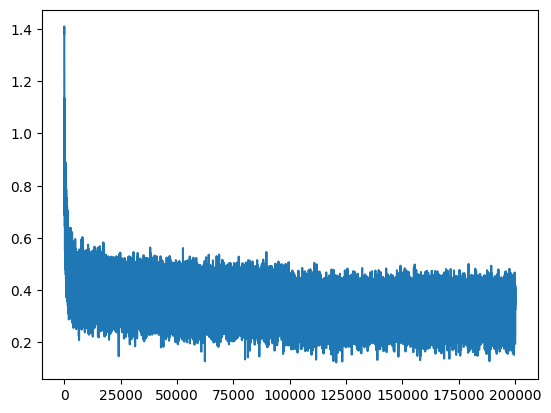

In [239]:
plt.plot(stepi, lossi)

In [240]:
emb = C[Xtr]   # [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # [32, 100]
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1311, grad_fn=<NllLossBackward0>)

In [241]:
emb = C[Xdev]   # [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # [32, 100]
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1745, grad_fn=<NllLossBackward0>)

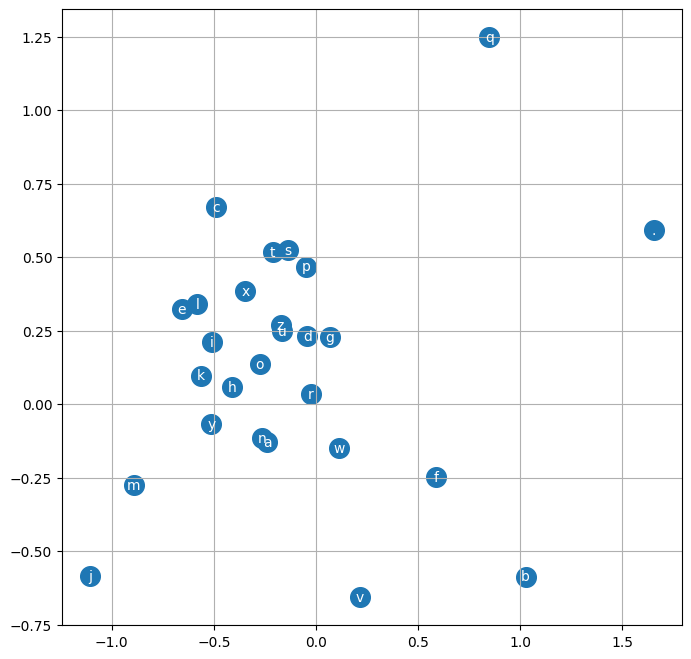

In [228]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [90]:
logits.max(1)

torch.return_types.max(
values=tensor([13.4214, 17.9616, 20.6613, 20.7198, 16.8601, 13.4214, 16.0936, 14.2867,
        16.0148, 18.5258, 16.0750, 21.0547, 13.4214, 17.2685, 17.2816, 20.2049,
        13.4214, 16.5877, 15.2851, 17.1984, 18.6979, 16.1043, 10.9960, 10.7945,
        15.5887, 13.4214, 16.3420, 17.0724, 12.8240, 16.3032, 19.2253, 16.1903],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

In [105]:
Y.shape

torch.Size([228146])

In [103]:
torch.randint(0, X.shape[0], (32,))

tensor([ 21349,   7859, 169587, 171777,  58117,  40460,  33081, 208613, 219449,
          2249,  56348,  96801,  54355, 211142, 176702,  64874, 184793, 103575,
        221774,  55544, 177657, 155057,  22241, 198356,  86777,  26908, 225666,
         29641, 218345,   8972, 203953,  43791])

In [176]:
# SPlit the dataset
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  # print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [242]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
kayah.
seel.
nihlyah.
rethrelendraeg.
adery.
seliigh.
popparekeiseana.
arleitziviona.
cayshabergahimies.
kinge.
jelionniella.
usmayven.
jamelizeks.
kayjahson.
daihlania.
yansun.
zakhlie.
ren.
cre.
